In [1]:
from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator

In [43]:
class EstimatorKNN(BaseEstimator):
    def __init__(self, n_neighbors=3):
        self.estimator = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree')

    def fit(self, x):
        self.estimator.fit(x)
        return self 

    def predict(self, x):
        return [1.0]*len(x) 
    
    def decision_function(self, x, y=None):
        distances, indices = self.estimator.kneighbors(x)
        outlier_level = distances[:,-1]
        return outlier_level

    def score(self, x, y=None):
        scores = self.decision_function(x)
        return sum(scores)/len(scores)

    def get_params(self, deep=True):
        return self.estimator.get_params(deep)

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self,parameter, value)
        return self

In [40]:
a = [[1,1],[2,1],[3,0],[4,0],[5,0],[6,1]]
[_a[0] for _a in a if _a[1] == 1]

[1, 2, 6]

In [41]:
#import estimator_knn as knn
import sys
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
import datasets
import pandas as pd
import numpy as np

def eval01():
    ds = datasets.load('data/raw/01_0[12]_01_*')
    column = ['rssi.a','rssi.b',['linear_accel[0]','linear_accel[1]','linear_accel[2]']]
    data_n, data_o = datasets.get_normalized_data(ds,
                                                  title_n='01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅',
                                                  title_o ='01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出',
                                                  before=6, after=0, column=column)
    
    knnModel = EstimatorKNN(n_neighbors=2)

    data_n = [d.flatten() for d in data_n]
    data_o = [d.flatten() for d in data_o]
    
    knnModel.fit(data_n)
    score = knnModel.score(data_n)
    print(score)
    score = knnModel.score(data_o)
    print(score)
    
    print(knnModel.get_params())

eval01()

path = data/raw/01_0[12]_01_*
data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
...
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
...
extracted 3 dataframes
extracted 3 dataframes
7.33426069735
196.530315749
{'n_jobs': 1, 'radius': 1.0, 'algorithm': 'ball_tree', 'n_neighbors': 2, 'leaf_size': 30, 'p': 2, 'metric': 'minkowski', 'metric_params': None}


In [97]:
import importlib
import datasets
importlib.reload(datasets)
importlib.reload(roc_auc)

path = data/raw/01_0*_01_*
data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
....................
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
....................
data/raw/01_03_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ帰宅
....................
['01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出'
 '01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅'
 '01_03_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ帰宅']
extracted 60 dataframes
['01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出']
extracted 20 dataframes


<module 'roc_auc' from 'roc_auc.ipynb'>

In [55]:
#import estimator_knn as knn
import sys
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
import datasets
import pandas as pd
import numpy as np

ds = datasets.load('data/raw/01_0[123]_0*_*')

path = data/raw/01_0[123]_0*_*
data/raw/01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅
...x................
data/raw/01_02_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ外出
....................
data/raw/01_01_03_4F実験室_XperiaZ3_胸ポケット_裏上_正常_5秒後まっすぐ帰宅
....................
data/raw/01_02_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ外出
....................
data/raw/01_01_04_4F実験室_XperiaZ3_カバン_裏上_正常_5秒後まっすぐ帰宅
....................
data/raw/01_03_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ帰宅
....................
data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
....................
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
....................
data/raw/01_03_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ帰宅
....................
data/raw/01_03_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ帰宅
....................


In [104]:
import importlib
importlib.reload(datasets)

path = data/raw/01_0*_01_*
data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
....................
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
....................
data/raw/01_03_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ帰宅
....................
['01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出'
 '01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅'
 '01_03_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ帰宅']
extracted 60 dataframes
['01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出']
extracted 20 dataframes


<module 'datasets' from 'datasets.ipynb'>

In [102]:
import datasets

['01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅']
extracted 19 dataframes
['01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅'
 '01_02_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ外出'
 '01_01_03_4F実験室_XperiaZ3_胸ポケット_裏上_正常_5秒後まっすぐ帰宅'
 '01_02_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ外出'
 '01_03_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ帰宅'
 '01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出'
 '01_03_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ帰宅'
 '01_03_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ帰宅']
extracted 159 dataframes
['01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅']
extracted 19 dataframes
['01_01_03_4F実験室_XperiaZ3_胸ポケット_裏上_正常_5秒後まっすぐ帰宅'
 '01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出'
 '01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅'
 '01_03_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ帰宅']
extracted 80 dataframes


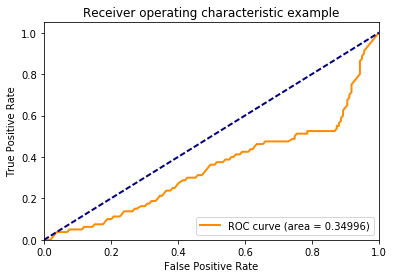

auc
0.349960691824


In [107]:
import importlib
#importlib.reload(roc_auc)
import roc_auc
import datasets

def eval01():
    column=['rssi.a','rssi.b', ['linear_accel[0]','linear_accel[1]','linear_accel[2]']]
    before = 10
    
    data_2d_base, data_2d_n = datasets.get_normalized_data(ds,
                                                           title_base='01_01_02.*',
                                                           title ='01_', # all anomaly data from iPhone
                                                           before=before, after=0,
                                                           column=column)
    
    data_2d_base, data_2d_o = datasets.get_normalized_data(ds,
                                                           title_base='01_01_02.*',
                                                           title ='.*4F.*Xperia.*胸ポケット.*_', # all anomaly data from iPhone
                                                           before=before, after=0,
                                                           column=column)

    model = EstimatorKNN()
    
    data_n = [d.ravel() for d in data_2d_n]
    data_o = [d.ravel() for d in data_2d_o]

    model.fit(data_n)
    score_n = model.decision_function(data_n)
    score_o = model.decision_function(data_o)
    auc = roc_auc.get_auc_from_normal_outlier(score_n, score_o)
    print('auc')
    print(auc)
    
eval01()